##### <span style="color:#483D8B; font-weight:bold;">Import Libraries</span>

In [1]:
!pip install pyspellchecker
!pip install symspellpy
!pip install evaluate
!pip install --upgrade transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.5 MB/s eta 0:00:00


In [2]:
import transformers
print(transformers.__version__)

4.52.4


In [3]:
#!pip uninstall preprocessing

In [4]:
import warnings

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import string
import re
#import preprocessor as p
import nltk
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from spellchecker import SpellChecker
from symspellpy.symspellpy import SymSpell, Verbosity
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
import warnings
import torch

In [6]:
from datasets import Dataset
from transformers import TrainingArguments
from transformers import Trainer
import evaluate
from transformers import EarlyStoppingCallback #to stop training early when eval loss stops improving
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from transformers import RobertaTokenizer, RobertaForSequenceClassification, RobertaTokenizerFast, RobertaConfig
from sklearn.metrics import accuracy_score, precision_recall_fscore_support #metric functions

##### <span style="color:#483D8B; font-weight:bold;">Import Dataset</span>

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
path = r"C:\Users\User\Desktop\Ironhack_DA\Final-project-hate-speech-detection-with-NLP\Dataset-Hate-Speech-Detection.csv"

In [9]:
path2 = "/content/drive/MyDrive/Dataset-Hate-Speech-Detection.csv"

In [10]:
df = pd.read_csv(path2, low_memory=False)

In [11]:
df

,class,tweet
0,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
...,...,...
24778,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...
24779,2,"you've gone and broke the wrong heart baby, an..."
24780,1,young buck wanna eat!!.. dat nigguh like I ain...
24781,1,youu got wild bitches tellin you lies


Classification:

- 0 - Hate Speech
- 1 - Offensive Language
- 2 - Neither/Neutral content

In [12]:
df.shape

(24783, 2)

In [13]:
df.reset_index(drop=True, inplace=True)
df.index = df.index + 0

In [14]:
df.head(5)

,class,tweet
0,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24783 entries, 0 to 24782
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   class   24783 non-null  int64 
 1   tweet   24783 non-null  object
dtypes: int64(1), object(1)
memory usage: 387.4+ KB


In [16]:
df.isnull().sum()

,0
class,0
tweet,0


NOTE: no null values & consistent datatypes

##### <span style="color:#483D8B; font-weight:bold;">Cleaning tweet column</span>

In [17]:
from IPython.display import display
pd.set_option('display.max_colwidth', None)

In [18]:
display(df.iloc[:10, :2])

,class,tweet
0,2,!!! RT @mayasolovely: As a woman you shouldn't complain about cleaning up your house. &amp; as a man you should always take the trash out...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn bad for cuffin dat hoe in the 1st place!!
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby4life: You ever fuck a bitch and she start to cry? You be confused as shit
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she look like a tranny
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you hear about me might be true or it might be faker than the bitch who told it to ya &#57361;
5,1,"!!!!!!!!!!!!!!!!!!""@T_Madison_x: The shit just blows me..claim you so faithful and down for somebody but still fucking with hoes! &#128514;&#128514;&#128514;"""
6,1,"!!!!!!""@__BrighterDays: I can not just sit up and HATE on another bitch .. I got too much shit going on!"""
7,1,!!!!&#8220;@selfiequeenbri: cause I'm tired of you big bitches coming for us skinny girls!!&#8221;
8,1,""" &amp; you might not get ya bitch back &amp; thats that """
9,1,""" @rhythmixx_ :hobbies include: fighting Mariam""\n\nbitch"


In [19]:
df[df['class'] == 0]

,class,tweet
85,0,"""@Blackman38Tide: @WhaleLookyHere @HowdyDowdy11 queer"" gaywad"
89,0,"""@CB_Baby24: @white_thunduh alsarabsss"" hes a beaner smh you can tell hes a mexican"
110,0,"""@DevilGrimz: @VigxRArts you're fucking gay, blacklisted hoe"" Holding out for #TehGodClan anyway http://t.co/xUCcwoetmn"
184,0,"""@MarkRoundtreeJr: LMFAOOOO I HATE BLACK PEOPLE https://t.co/RNvD2nLCDR"" This is why there's black people and niggers"
202,0,"""@NoChillPaz: ""At least I'm not a nigger"" http://t.co/RGJa7CfoiT""\n\nLmfao"
...,...,...
24576,0,this guy is the biggest faggot omfg
24685,0,"which one of these names is more offensive kike, wop, kraut, wetback jigaboo, towelhead, gook, or redskin."
24751,0,you a pussy ass nigga and I know it nigga.
24776,0,you're all niggers


In [20]:
df.groupby('class').nunique()

,tweet
class,
0,1430
1,19190
2,4163


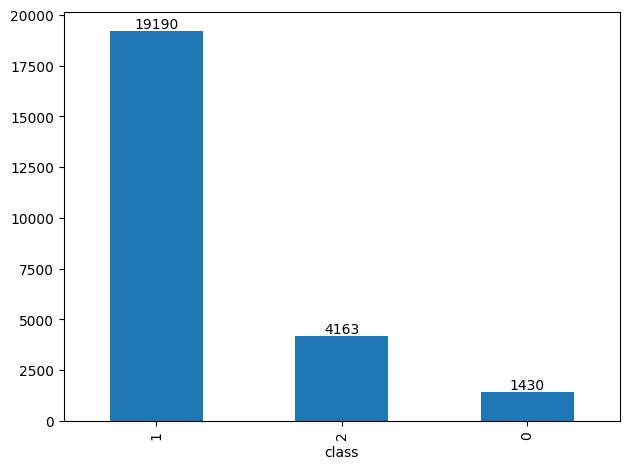

In [21]:
class_count = df['class'].value_counts()

ax = class_count.plot(kind='bar')

for i, value in enumerate(class_count):
    ax.text(i, value + 0.5, str(value), ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

In [22]:
display(df.iloc[:5, :2])

,class,tweet
0,2,!!! RT @mayasolovely: As a woman you shouldn't complain about cleaning up your house. &amp; as a man you should always take the trash out...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn bad for cuffin dat hoe in the 1st place!!
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby4life: You ever fuck a bitch and she start to cry? You be confused as shit
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she look like a tranny
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you hear about me might be true or it might be faker than the bitch who told it to ya &#57361;


In [23]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [24]:
max_edit_distance_dictionary = 2
prefix_length = 7
sym_spell = SymSpell(max_edit_distance_dictionary, prefix_length)

dictionary_path = "frequency_dictionary_en_82_765.txt"  # path to the downloaded dictionary
sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1)

#p.set_options(p.OPT.URL, p.OPT.MENTION, p.OPT.EMOJI)

stop_words = set(stopwords.words('english'))
punctuation = string.punctuation
tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)

def correct_spelling_symspell(text):
    corrected_words = []
    for word in text.split():
        # Skip short words and stopwords to speed up
        if len(word) < 3 or word in stop_words:
            corrected_words.append(word)
            continue

        suggestions = sym_spell.lookup(word, Verbosity.CLOSEST, max_edit_distance=2)
        if suggestions:
            corrected_words.append(suggestions[0].term)
        else:
            corrected_words.append(word)
    return " ".join(corrected_words)

def clean_tweet(text):
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove mentions
    text = re.sub(r'@\w+', '', text)
    # Remove hashtags (optional: keep the text if you want)
    text = re.sub(r'#\w+', '', text)
    # Remove emojis
    emoji_pattern = re.compile(
        "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags
        "]+",
        flags=re.UNICODE
    )
    text = emoji_pattern.sub(r'', text).strip()
    text = correct_spelling_symspell(text)
    pattern = r'([{}])\1+'.format(re.escape(punctuation))
    text = re.sub(pattern, r'\1', text)
    tokens = tokenizer.tokenize(text)
    words = [w for w in tokens if w not in stop_words]
    return " ".join(words)

df['tweet_cleaned'] = df['tweet'].apply(clean_tweet)

2025-06-26 15:09:34,138: E symspellpy.symspellpy] Dictionary file not found at frequency_dictionary_en_82_765.txt.
ERROR:symspellpy.symspellpy:Dictionary file not found at frequency_dictionary_en_82_765.txt.


In [25]:
df['tweet_cleaned'] = df['tweet_cleaned'].str.replace(r'!\s*rt\s*:', '', regex=True).str.replace(r"[^\w\s.,!?']", "", regex=True)

In [26]:
df

,class,tweet,tweet_cleaned
0,2,!!! RT @mayasolovely: As a woman you shouldn't complain about cleaning up your house. &amp; as a man you should always take the trash out...,woman complain cleaning house . man always take trash .
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn bad for cuffin dat hoe in the 1st place!!,boy dats cold.tyga dwn bad cuffin dat hoe 1st place !
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby4life: You ever fuck a bitch and she start to cry? You be confused as shit,! rt dawg ever fuck bitch start cry ? confused shit
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she look like a tranny,look like tranny
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you hear about me might be true or it might be faker than the bitch who told it to ya &#57361;,shit hear might true might faker bitch told ya
...,...,...,...
24778,1,"you's a muthaf***in lie &#8220;@LifeAsKing: @20_Pearls @corey_emanuel right! His TL is trash &#8230;. Now, mine? Bible scriptures and hymns&#8221;","you's muthaf lie right ! tl trash . , mine ? bible scriptures hymns"
24779,2,"you've gone and broke the wrong heart baby, and drove me redneck crazy","gone broke wrong heart baby , drove redneck crazy"
24780,1,young buck wanna eat!!.. dat nigguh like I aint fuckin dis up again,young buck wanna eat ! . dat nigguh like aint fuckin dis
24781,1,youu got wild bitches tellin you lies,youu got wild bitches tellin lies


- Word cloud, to find common words in each class
- NLP techniques to get insights

##### <span style="color:#483D8B; font-weight:bold;">Model bulding</span>

##### <span style="color:#483D8B; font-weight:bold;">1 - Handling Imbalanced Data</span>

In [27]:
df.groupby('class').nunique()

,tweet,tweet_cleaned
class,,
0,1430,1396
1,19190,18834
2,4163,4090


In [28]:
df.drop('tweet', inplace = True, axis=1)

In [29]:
df = df.drop_duplicates(subset='tweet_cleaned', keep='first').reset_index(drop=True)

In [30]:
multi_class_tweets = df.groupby('tweet_cleaned')['class'].nunique()

tweets_with_multiple_classes = multi_class_tweets[multi_class_tweets > 1]

print(tweets_with_multiple_classes)

Series([], Name: class, dtype: int64)


In [31]:
df_0 = df[df['class'] == 0]   # All hate speech tweets
df_1 = df[df['class'] == 1]   # All offensive tweets
df_2 = df[df['class'] == 2]   # All neutral tweets

In [32]:
max_size = df_1.shape[0]
max_size

#there are duplicate rows

18820

In [33]:
df.groupby('class').nunique()

,tweet_cleaned
class,
0,1387
1,18820
2,4083


In [34]:
df_0_upsampled = resample(df_0, replace=True, n_samples=max_size, random_state=42)
df_2_upsampled = resample(df_2, replace=True, n_samples=max_size, random_state=42)

In [35]:
df_balanced = pd.concat([df_0_upsampled, df_2_upsampled, df_1])

In [36]:
df_balanced.groupby('class').count()

,tweet_cleaned
class,
0,18820
1,18820
2,18820


In [37]:
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

In [38]:
df_balanced.groupby('class').count()

,tweet_cleaned
class,
0,18820
1,18820
2,18820


In [39]:
df_balanced.head(2)

,class,tweet_cleaned
0,1,"pulled bulbasuar , know bout make yo girl pussy sore"
1,1,crazy bitch call 10 times one hour


In [40]:
df_balanced["char_length"] = df_balanced["tweet_cleaned"].apply(len)
print(df_balanced["char_length"].describe())

count    56460.000000
mean        49.998388
std         25.915458
min          0.000000
25%         29.000000
50%         47.000000
75%         69.000000
max        195.000000
Name: char_length, dtype: float64


##### <span style="color:#483D8B; font-weight:bold;">2 - RoBERTa model bulding</span>

Using a lighter version or Roberta, distilroberta-base

In [41]:
df_reduced = df_balanced.groupby('class', group_keys=False).apply(lambda x: x.sample(frac=0.8, random_state=42)).reset_index(drop=True) #changed from 0.7 to 0.8

/tmp/ipython-input-41-3070809943.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_reduced = df_balanced.groupby('class', group_keys=False).apply(lambda x: x.sample(frac=0.8, random_state=42)).reset_index(drop=True) #changed from 0.7 to 0.8


In [42]:
df_reduced = df_reduced.drop(columns=['char_length'])

In [43]:
df_reduced.groupby('class').count()

,tweet_cleaned
class,
0,15056
1,15056
2,15056


In [44]:
X = df_reduced["tweet_cleaned"]
y = df_reduced["class"]

In [45]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

In [46]:
tokenizer = RobertaTokenizerFast.from_pretrained("distilroberta-base")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

In [47]:
train_encodings = tokenizer(list(X_train), truncation=True, padding=True, max_length=150) # changed the length (actuals length 147)
test_encodings = tokenizer(list(X_test), truncation=True, padding=True, max_length=150)

In [48]:
class TweetDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels.reset_index(drop=True)
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels.iloc[idx])
        return item
    def __len__(self):
        return len(self.labels)

train_dataset = TweetDataset(train_encodings, y_train)
test_dataset = TweetDataset(test_encodings, y_test)

In [49]:
config = RobertaConfig.from_pretrained(
        "distilroberta-base",
        num_labels=3,
        hidden_dropout_prob=0.3,                  # Increase dropout to help prevent overfitting
        attention_probs_dropout_prob=0.3          # Dropout in attention layers too
)

In [50]:
model = RobertaForSequenceClassification.from_pretrained("distilroberta-base", config=config)

model.safetensors:   0%|          | 0.00/331M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [51]:
training_args = TrainingArguments(
    output_dir='./results',  # Where to save model outputs and checkpoints
    num_train_epochs=8,     # Train up to 8 epochs - this is the best checkpoint (initially it was 10)
    per_device_train_batch_size=20, # Number of samples per batch for training
    per_device_eval_batch_size=20, # Number of samples per batch for evaluation
    logging_dir='./logs',          # Directory for training logs
    logging_steps=1000,             # Log training info every 1000 steps
    # no_cuda=True  # to force CPU usage if needed
    eval_strategy="epoch",              # Run evaluation after every epoch to check model performance
    save_strategy="epoch",                    # Save model checkpoint after each epoch
    load_best_model_at_end=True,              # After training, load the checkpoint with best evaluation loss
    metric_for_best_model="eval_loss",        # Use evaluation loss to determine which checkpoint is best
    weight_decay=0.01                         # Add weight decay (L2 regularization) to prevent overfitting
)

In [52]:
early_stopping = EarlyStoppingCallback(
    early_stopping_patience=2                 # Stop training if eval loss does not improve for 2 consecutive epochs
)

In [53]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)

    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [54]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,          # function for evaluating metrics
    callbacks=[early_stopping],               # Enable early stopping during training
)

In [55]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: gkoutroumanos (gkoutroumanos-ironhack) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.607800,0.421349,0.855546,0.855871,0.862162,0.855546
2,0.389300,0.345951,0.881005,0.880148,0.891701,0.881005
3,0.306300,0.295486,0.903476,0.902963,0.910040,0.903476
4,0.257300,0.250315,0.923511,0.922874,0.927835,0.923511
5,0.212100,0.243375,0.934802,0.934136,0.938712,0.934802
6,0.194800,0.254259,0.933916,0.933537,0.936448,0.933916
7,0.179600,0.227560,0.943547,0.943003,0.946320,0.943547
8,0.157300,0.229334,0.945428,0.945013,0.947587,0.945428


TrainOutput(global_step=14456, training_loss=0.2809644555544154, metrics={'train_runtime': 3969.9286, 'train_samples_per_second': 72.815, 'train_steps_per_second': 3.641, 'total_flos': 1.0396032280202016e+16, 'train_loss': 0.2809644555544154, 'epoch': 8.0})

In [56]:
trainer = Trainer(
    model=model,
    args=training_args,
    eval_dataset=test_dataset,  # only evaluation dataset here
)

eval_results = trainer.evaluate()  # evaluates the model on test_dataset
print(eval_results)

{'eval_loss': 0.22755973041057587, 'eval_model_preparation_time': 0.0015, 'eval_runtime': 17.9547, 'eval_samples_per_second': 503.155, 'eval_steps_per_second': 25.174}


epoch 8 is the best model checkpoint

eval_loss improved 0.2153 (average prediction error) at epoch 8

The model is randomly guessing the correct answer, eval_loss: 1.1

Save the model

In [57]:
trainer.save_model("best_model")
tokenizer.save_pretrained("best_model")

('best_model/tokenizer_config.json',
 'best_model/special_tokens_map.json',
 'best_model/vocab.json',
 'best_model/merges.txt',
 'best_model/added_tokens.json',
 'best_model/tokenizer.json')

Predict for new data

In [58]:
predictions = trainer.predict(test_dataset)

              precision    recall  f1-score   support

           0       0.89      0.99      0.94      3025
           1       0.97      0.86      0.91      3034
           2       0.97      0.98      0.98      2975

    accuracy                           0.94      9034
   macro avg       0.95      0.94      0.94      9034
weighted avg       0.95      0.94      0.94      9034



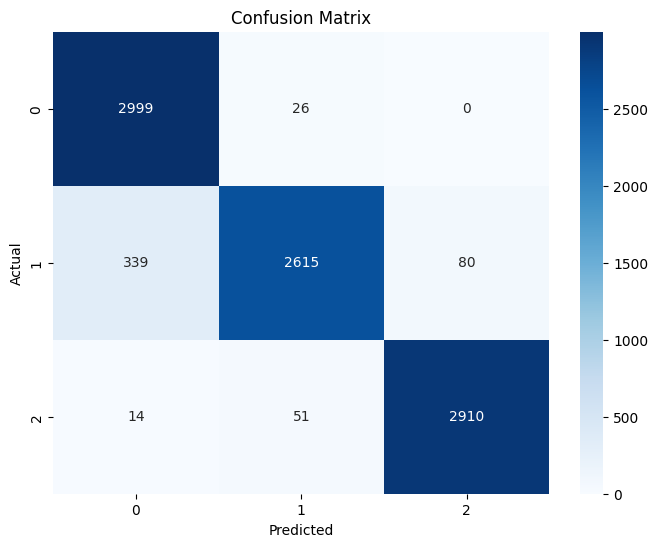

In [59]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Run prediction
predictions = trainer.predict(test_dataset)

# Get predicted class labels
preds = np.argmax(predictions.predictions, axis=1)

# Get true labels
true_labels = predictions.label_ids

# Print classification report
print(classification_report(true_labels, preds))

# Confusion matrix
cm = confusion_matrix(true_labels, preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [60]:
train_loss = [0.6166, 0.3918, 0.3126, 0.2611, 0.2200, 0.2003, 0.1841, 0.1603, 0.1478, 0.1297]
val_loss =   [0.4149, 0.3316, 0.2974, 0.2672, 0.2715, 0.2544, 0.2531, 0.2153, 0.2289, 0.2511]
epochs = list(range(1, 11))

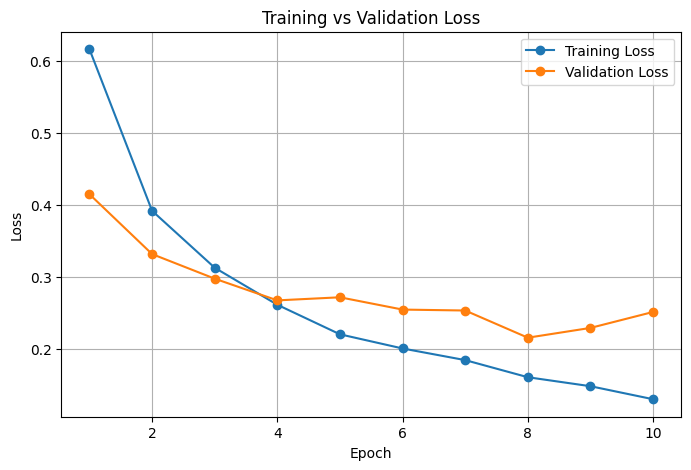

In [61]:
plt.figure(figsize=(8, 5))
plt.plot(epochs, train_loss, label='Training Loss', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()